# Bank Marketing AutoAI Model Test

### Watson Machine Learning認証情報の設定

In [1]:
wml_credentials = {
  "apikey": "xxxx",
  "instance_id": "xxxx",
  "url": "https://us-south.ml.cloud.ibm.com"
}    

### APIのScoring URL設定

In [2]:
# scoring URLの設定
scoring_url = "xxxx"

### 必要ライブラリのimport

In [3]:
import urllib3, requests, json
import urllib.request
import numpy as np
import pandas as pd
from IPython.display import display

### Watson ML呼出し準備

In [ ]:
# トークン取得
apikey = wml_credentials["apikey"]

# Get an IAM token from IBM Cloud
url     = "https://iam.bluemix.net/oidc/token"
headers = { "Content-Type" : "application/x-www-form-urlencoded" }
data    = "apikey=" + apikey + "&grant_type=urn:ibm:params:oauth:grant-type:apikey"
IBM_cloud_IAM_uid = "bx"
IBM_cloud_IAM_pwd = "bx"
response  = requests.post( url, headers=headers, data=data, 
        auth=( IBM_cloud_IAM_uid, IBM_cloud_IAM_pwd ) )
iam_token = response.json()["access_token"]

print('iam_token = ', iam_token)

In [5]:
# Header の組立て
header_token = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + iam_token}
ml_instance_id = wml_credentials["instance_id"]
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + iam_token, 'ML-Instance-ID': ml_instance_id}

### テスト用CSV読み込み
学習に利用していない 521件のデータをまとめて読み込みます。

In [7]:
# ファイルをカレントディレクトリにダウンロード
csv_url = 'https://raw.githubusercontent.com/makaishi2/sample-data/master/data/bank-4000-rest.csv'
csv_filename = 'bank-4000-rest.csv'
urllib.request.urlretrieve(csv_url, csv_filename)

('bank-4000-rest.csv', <http.client.HTTPMessage at 0x7f4c4e29c6d8>)

In [8]:
# データフレームに読み込み
df_bank_test = pd.read_csv('bank-4000-rest.csv', names=["age","job","marital","education","default","balance",
    "housing","loan","contact","day","month","duration","campaign","pdays","previous","poutcome","Y"])

In [9]:
display(df_bank_test.head())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Y
0,53,admin.,divorced,secondary,no,26,yes,no,cellular,7,may,56,1,359,1,failure,no
1,36,technician,married,secondary,no,191,no,no,cellular,31,aug,69,1,-1,0,unknown,no
2,58,technician,divorced,secondary,no,-123,no,no,cellular,5,aug,131,2,-1,0,unknown,no
3,26,student,single,secondary,no,-147,no,no,unknown,4,jun,95,2,-1,0,unknown,no
4,34,technician,single,secondary,no,179,no,no,cellular,19,aug,294,3,-1,0,unknown,no


### 正解データ correctの抽出

In [10]:
correct = df_bank_test['Y'].values
print(correct[:50])

['no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'yes' 'no' 'no' 'no' 'no'
 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'yes' 'no' 'no' 'no' 'no' 'no' 'no'
 'yes' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'yes' 'no'
 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no']


### API呼出し用入力データ配列の作成

In [11]:
df_sub = df_bank_test.copy()

# 目的変数列の削除
df_sub = df_sub.drop('Y', axis=1)

# np.nan値をNoneに置き換え
df_sub = df_sub.where((pd.notnull(df_sub)), None)

In [12]:
display(df_sub.head())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,53,admin.,divorced,secondary,no,26,yes,no,cellular,7,may,56,1,359,1,failure
1,36,technician,married,secondary,no,191,no,no,cellular,31,aug,69,1,-1,0,unknown
2,58,technician,divorced,secondary,no,-123,no,no,cellular,5,aug,131,2,-1,0,unknown
3,26,student,single,secondary,no,-147,no,no,unknown,4,jun,95,2,-1,0,unknown
4,34,technician,single,secondary,no,179,no,no,cellular,19,aug,294,3,-1,0,unknown


In [13]:
# DataFrameから項目名Listの生成
fields = df_sub.columns.tolist()
print(fields)

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']


In [14]:
# DataFrameから入力用Listの生成
values = df_sub.values.tolist()
# テスト用
#values = df_sub.head(2).values.tolist()
print(values[:2])

[[53, 'admin.', 'divorced', 'secondary', 'no', 26, 'yes', 'no', 'cellular', 7, 'may', 56, 1, 359, 1, 'failure'], [36, 'technician', 'married', 'secondary', 'no', 191, 'no', 'no', 'cellular', 31, 'aug', 69, 1, -1, 0, 'unknown']]


In [15]:
# payload変数の組立て
payload_scoring = {"input_data": [{
    "fields": fields, 
    "values": values
}]}

### APIの呼出し

In [16]:
# APIの呼出し
response_scoring = requests.post(scoring_url,  json=payload_scoring, headers=header)

### 戻り値のparese

In [17]:
# 戻り値のparse
res = json.loads(response_scoring.text)

pred = res['predictions'][0]
pred_values = pred['values']
pred_fields = pred['fields']
df_res = pd.DataFrame(pred_values, columns = pred_fields)

In [18]:
display(df_res.head())

,prediction,probability
0,no,"[0.9413460860089278, 0.05865391399107223]"
1,no,"[0.9839439849098387, 0.016056015090161264]"
2,no,"[0.9689762848893887, 0.0310237151106113]"
3,no,"[0.983296011477629, 0.016703988522371004]"
4,no,"[0.9097652531664269, 0.09023474683357308]"


### 精度評価

In [19]:
# 予測値の抽出
prediction = df_res['prediction'].values

# 確率値のリスト取得
w1 = df_res['probability'].values.tolist()
probas = [item[1] for item in w1]

In [20]:
# Accuracyの計算
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(correct, prediction)

In [21]:
# ROC AUCの計算
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

# fpr, tpr値の取得
fpr, tpr, thresholds = roc_curve(correct, probas, pos_label='yes')

# ROC AUCの計算
roc_auc = auc(fpr, tpr)

In [22]:
# 混同行列の計算
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(correct, prediction)
df_matrix = pd.DataFrame(matrix, columns=['no', 'yes'], index=['no', 'yes'])

### 精度評価結果表示

In [23]:
### 混同行列表示
display(df_matrix)

,no,yes
no,447,11
yes,41,22


#### 上記の意味

元々は10件に1件しか成約がなかったのが、  
モデルで予測することにより63件中22件成約できることになります。

In [24]:
# AccuracyとROC AUCの表示

print("Accuracy: %0.3f" % accuracy)
print("ROC AUC : %0.3f" % roc_auc)

Accuracy: 0.900
ROC AUC : 0.887


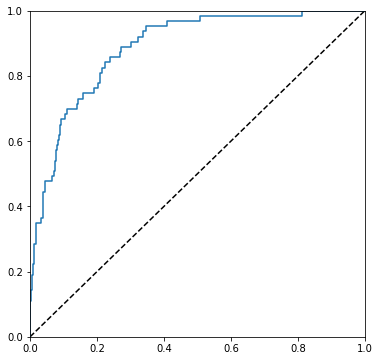

In [25]:
# ROC曲線の描画

%matplotlib inline 
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.clf()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()

In [26]:
# 正解データの yesとnoの数の計算
y_count = np.count_nonzero(correct == 'yes')
n_count = np.count_nonzero(correct == 'no')
print(y_count, n_count)

# 予測値がyesだったもののうち、正解データのyesとnoの数
yy_count = df_matrix['yes']['yes']
yn_count = df_matrix['no']['yes']
print(yy_count, yn_count)


63 458
22 41


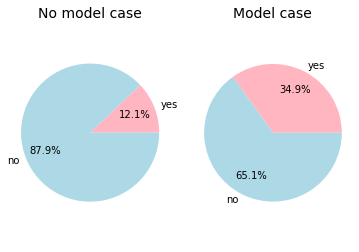

In [27]:
# モデルを使わない場合と使った場合の成約率の比較

plt.subplot(1, 2, 1)
label = ['yes', 'no']
colors = ["lightpink", "lightblue"]
x = np.array([y_count, n_count])
plt.pie(x, labels=label, colors=colors,
       autopct="%1.1f%%", pctdistance=0.7)
plt.title('No model case', fontsize=14)
plt.axis('equal')
 
plt.subplot(1, 2, 2)
label = ['yes', 'no']
colors = ["lightpink", "lightblue"]
x = np.array([yy_count, yn_count])
plt.pie(x, labels=label, colors=colors,
       autopct="%1.1f%%", pctdistance=0.7)
plt.title('Model case', fontsize=14)
plt.axis('equal')

plt.show()